# Comparing similarities between images 

In [1]:
# from skimage.measure import compare_ssim as ssim
from sklearn.metrics import pairwise_distances
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from keras.applications import VGG16

In [3]:
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

## Method 1: Euclidean distance and SSIM

In [47]:
def mse(x,y): return np.sqrt(((x-y)**2).sum())/(x.shape[0])

def show_images():
    for i, img in enumerate(images):
        plt.subplot(131+i)
        plt.imshow(img/255.0)
        
def calculate_scores(images, ssim=False):
    org = images[0]
    
    for i, img in enumerate(images):
        mse_score = mse(org.flatten(), img.flatten())
        if ssim: 
            ssim_score = ssim(org, img, multichannel=True)
            label = "For image {}; MSE: {:.4f}, SSIM: {:.4f}"
            print(label.format(i, mse_score, ssim_score ))
        else:
            label = "For image {}; MSE: {:.4f}"
            print(label.format(i, mse_score))

In [32]:
image_names = ['cat1.jpg', 'cat2.png', 'cat_d.jpg']
imgs = []
for img in image_names:
    imgs.append(image.img_to_array(image.load_img(img, target_size=(150,150))))
    
images = np.array(imgs)

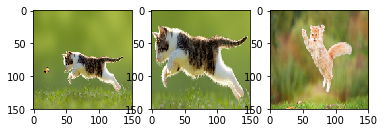

In [33]:
show_images()

In [34]:
# Lower the MSE, closer the images. 
# Higher the SSIM, closer the image. Max values of SSIM is 1
calculate_scores(images) 

For image 0; MSE: 0.0000, SSIM: 1.0000
For image 1; MSE: 0.1973, SSIM: 0.0055
For image 2; MSE: 0.2075, SSIM: 0.0061


### Results:
Not very satsifactory (as expected). These methods uses vector operations to find distance between two 3D-vector and have not general understanding of the image. Operations like scaling, light, rotation, etc drastically changes the pixel values resulting in high distance between the same looking (to humans) images. 

## Method 2: CNNs for features extraction

In [39]:
model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

In [40]:
features = model.predict(images)

In [42]:
features.shape

(3, 4, 4, 512)

In [69]:
## using different distance metrics
def calculate_scores_dist(images, dist='euclidean'):
    distances = pairwise_distances(images.reshape(len(images), -1), metric= dist)[0]
    for i,d in enumerate(distances):
        print('{} for image {:.4f}; {:.4f}'.format(dist, i, d))

In [70]:
calculate_scores_dist(features)

euclidean for image 0.0000; 0.0000
euclidean for image 1.0000; 1968.6661
euclidean for image 2.0000; 1739.9182


In [73]:
for d in ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']:
    calculate_scores_dist(features,dist=d)
    print()

cityblock for image 0.0000; 0.0000
cityblock for image 1.0000; 62297.4134
cityblock for image 2.0000; 52524.4010

cosine for image 0.0000; 0.0000
cosine for image 1.0000; 0.5999
cosine for image 2.0000; 0.7434

euclidean for image 0.0000; 0.0000
euclidean for image 1.0000; 1968.6661
euclidean for image 2.0000; 1739.9182

l1 for image 0.0000; 0.0000
l1 for image 1.0000; 62297.4134
l1 for image 2.0000; 52524.4010

l2 for image 0.0000; 0.0000
l2 for image 1.0000; 1968.6661
l2 for image 2.0000; 1739.9182

manhattan for image 0.0000; 0.0000
manhattan for image 1.0000; 62297.4134
manhattan for image 2.0000; 52524.4010



### Results:
Again, not very satisfactory. Possible problems could be, the features generated by VGG16 are meaningful but our distance fails to capture it. The approach of taking difference of corresepinding elements might not be the right approach. I also tried using different distance metrics. Still the same results. All the distances think that image-3 is more closer to image-1 than image-2, which is not True.

## Method 3: Going completely DL (CNNs - feature extaction & FC - classification) 

In [75]:
# to do
# build siamese model, use full vgg16 for feature Extraction.
# build siamese model, use only first 3/4 blocks of layers for Feature extraction.
# making data generator, should take 2 images and return 2images + [0,1], whether similar or not.

### Loading the data

In [4]:
path = 'data/'

In [5]:
pd.__version__

'0.23.4'

In [9]:
from sklearn.model_selection import train_test_split
data_train = pd.read_csv(f'{path}fashion-mnist_train.csv')
X_full = data_train.iloc[:,1:]
y_full = data_train.iloc[:,:1]
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size = 0.3)

In [10]:
x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.values.astype('int')
y_test = y_test.values.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (42000, 28, 28, 1) 1.0
Testing (18000, 28, 28, 1) 1.0


In [11]:
# reorganize by groups
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [4137, 4179, 4196, 4225, 4207, 4209, 4190, 4213, 4252, 4192]
test groups: [1863, 1821, 1804, 1775, 1793, 1791, 1810, 1787, 1748, 1808]


### Making batches

In [25]:
test_groups[3].shape

(1754, 28, 28, 1)

In [26]:
np.random.choice(range(10))

9

In [12]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    """ Helper function that generated pair of images of which first half are similar and second half are diffirent"""
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
            
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
            
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)



In [31]:
a,b, s = gen_random_batch(test_groups, 2)

In [33]:
a.shape, b.shape

((4, 28, 28, 1), (4, 28, 28, 1))

In [34]:
s

array([1, 1, 0, 0])

### Building the model

In [14]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout

In [14]:
img_in = Input(shape = (28,28,1), name = 'FeatureNet_ImageInput')
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation = 'linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs = [img_in], outputs = [n_layer], name = 'FeatureGenerationModel')
feature_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeatureNet_ImageInput (Input (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 16)        0         
__________

In [15]:
from keras.layers import concatenate
img_a_in = Input(shape = (28,28,1), name = 'ImageA_Input')
img_b_in = Input(shape = (28,28,1), name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageA_Input (InputLayer)       (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
ImageB_Input (InputLayer)       (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
FeatureGenerationModel (Model)  (None, 32)           25040       ImageA_Input[0][0]               
                                                                 ImageB_Input[0][0]               
__________________________________________________________________________________________________
merge_features (Concatenate)    (None, 64)           0           FeatureGenerationModel[1][0]     
          

In [16]:
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

In [23]:
feature_model.save('feature_model.h5')

In [24]:
similarity_model.save('similarity_model.h5')

### Loading saved model

<span style="color:red">Only to be used when you want to load pre-trained weights.</span>

In [15]:
from keras.models import load_model

In [17]:
feature_model = load_model('models/feature_model.h5')
similarity_model = load_model('models/similarity_model.h5')

C:\Users\Computer World\Anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [19]:
feature_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeatureNet_ImageInput (Input (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 16)        0         
__________

In [18]:
similarity_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageA_Input (InputLayer)       (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
ImageB_Input (InputLayer)       (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
FeatureGenerationModel (Model)  (None, 32)           25040       ImageA_Input[0][0]               
                                                                 ImageB_Input[0][0]               
__________________________________________________________________________________________________
merge_features (Concatenate)    (None, 64)           0           FeatureGenerationModel[1][0]     
          

### Looking at the model predictions

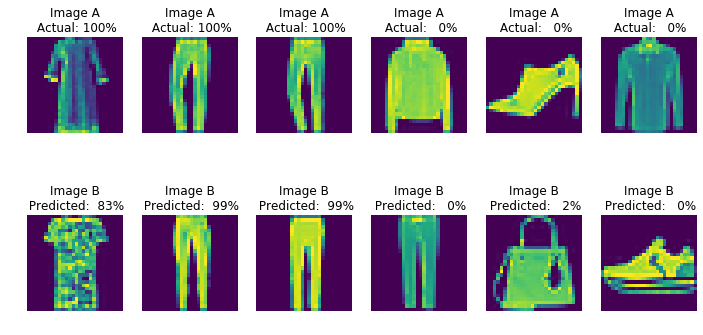

In [20]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

___
**Note**: Only run the cell in this section if you are training the model. You don't have to run them if you are using pre-trained weights.

In [18]:
## Don't run this if your have used the pre-trained weights
## This cell is meant for training the model, you don't have to train it again if you have loaded the model directly.
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024) #1024
loss_history = similarity_model.fit_generator(siam_gen(train_groups), 
                               steps_per_epoch = 500, # 500
                               validation_data=([valid_a, valid_b], valid_sim),
                                              epochs = 10, # 10
                                             verbose = True)

Epoch 1/10
500/500 [==============================] - 28s 56ms/step - loss: 0.7093 - mean_absolute_error: 0.4920 - val_loss: 0.6642 - val_mean_absolute_error: 0.4817
Epoch 2/10
500/500 [==============================] - 25s 50ms/step - loss: 0.6262 - mean_absolute_error: 0.4515 - val_loss: 0.5365 - val_mean_absolute_error: 0.3954
Epoch 3/10
500/500 [==============================] - 25s 50ms/step - loss: 0.5374 - mean_absolute_error: 0.3829 - val_loss: 0.4478 - val_mean_absolute_error: 0.3129
Epoch 4/10
500/500 [==============================] - 24s 47ms/step - loss: 0.4688 - mean_absolute_error: 0.3250 - val_loss: 0.3859 - val_mean_absolute_error: 0.25514 -
Epoch 5/10
500/500 [==============================] - 24s 47ms/step - loss: 0.4374 - mean_absolute_error: 0.2947 - val_loss: 0.3612 - val_mean_absolute_error: 0.2332
Epoch 6/10
500/500 [==============================] - 24s 48ms/step - loss: 0.4184 - mean_absolute_error: 0.2778 - val_loss: 0.3410 - val_mean_absolute_error: 0.2132
E

In [23]:
feature_model.save('feature_model.h5')

In [24]:
similarity_model.save('similarity_model.h5')

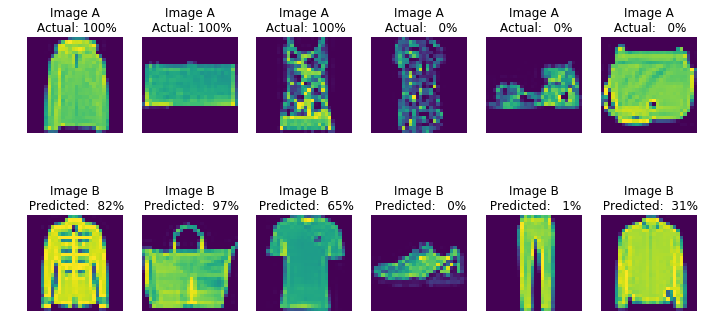

In [19]:
_ = show_model_output()

### Examining the features

In [20]:
x_test_features = feature_model.predict(x_test, verbose = True, batch_size=128)

18000/18000 [==============================] - 1s 77us/step


In [21]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                         init='pca',
                         random_state=101,
                         method='barnes_hut',
                         n_iter=500,
                         verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.094s...
[t-SNE] Computed neighbors for 18000 samples in 3.983s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for sam

In [ ]:
gen_random_batch(test_groups, nb_exampl)

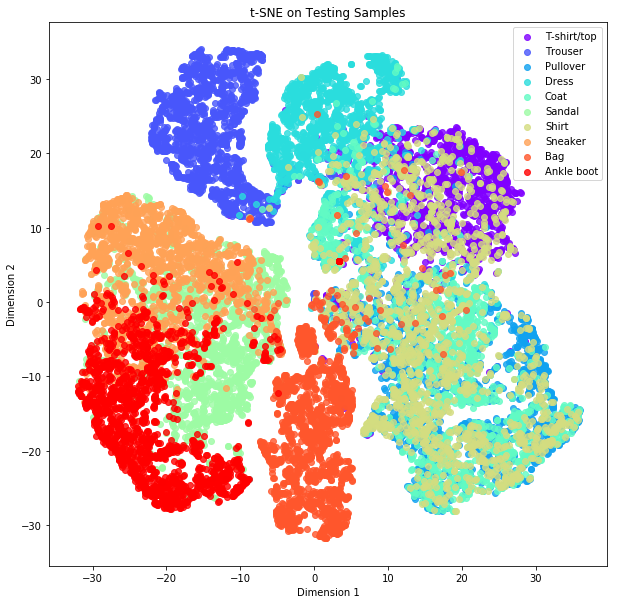

In [22]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
                tsne_features[np.where(y_test == c_group), 1],
                marker='o',
                color=c_color,
                linewidth='1',
                alpha=0.8,
                label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)

### Results

The model is easily able to distinguish Ankle boot, bag, Trouser and Dress (nicely seperated and non-overlapping clusters) but the model is having really hard time identifying shirt, coat and t-shirt/top (tightly entangled, overlapping clusters).

Also its reasonable, because shirt, t-shirt and top are all similar in appearance. And items like bag, trouser, sandal and boots are different in appearance. Hence, can be easily identified. 

Remark: More images of shirt, t-shirt and top showcasing features specific to them can help to get better scores. By providing more such explicit features will make the learning process easy for the model.

### Making predictions

In [75]:
n_load = 1000 # number of images to load from the database (here test.csv)
n_show = 10 # show first and last 'n' images based on similarity

In [71]:
def load_db(n):
    db = pd.read_csv(f'{path}fashion-mnist_test.csv').head(n)
    X = db.iloc[:,1:]
    y = db.iloc[:,:1]
    X = X.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
    y = y.values.astype('int')
    print('db', X.shape, y.shape)
    return X, y

db_img, labels = load_db(n_load) # number of images to load into the database

db (1000, 28, 28, 1) (1000, 1)


In [103]:
def plot_similar(pred, n=10):
    imgs = db_img[pred.index[:n]]
    fig, m_axs = plt.subplots(n//3, 3, figsize = (12, 6))
    for img, p, ax1 in zip(imgs,pred[:n], m_axs.reshape(-1)):
        ax1.imshow(img[:,:,0])
        ax1.set_title('High Similarity: %3.0f%%' % (100*p))
        ax1.axis('off')
    
    imgs = db_img[pred.index[-n:]]
    fig2, m_axs2 = plt.subplots(n//3, 3, figsize = (12, 6))
    for img, p, ax1 in zip(imgs,pred[-n:], m_axs2.reshape(-1)):
        ax1.imshow(img[:,:,0])
        ax1.set_title('Low Similarity: %3.0f%%' % (100*p))
        ax1.axis('off')
    
    imgs = db_img[pred.index[int(len(pred)*0.2):int(len(pred)*0.2)+n]]
    fig3, m_axs3 = plt.subplots(n//3, 3, figsize = (12, 6))
    for img, p, ax1 in zip(imgs,pred[int(len(pred)*0.2):int(len(pred)*0.2)+n], m_axs3.reshape(-1)):
        ax1.imshow(img[:,:,0])
        ax1.set_title('Moderate Similarity: %3.0f%%' % (100*p))
        ax1.axis('off')
    
    return fig, fig2, fig3

In [100]:
def make_predict(image, n_show=10):
    pred = similarity_model.predict([np.array([image,]*n_load), db_img])
    pred = pd.Series(pred[:, 0]).sort_values(ascending=False)
    plt.imshow(image[:,:,0])
    plt.title('Original Image')
    plot_similar(pred, n_show)
    return pred

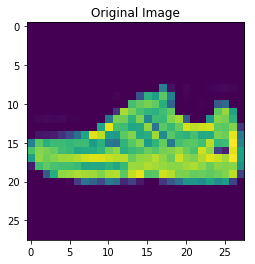

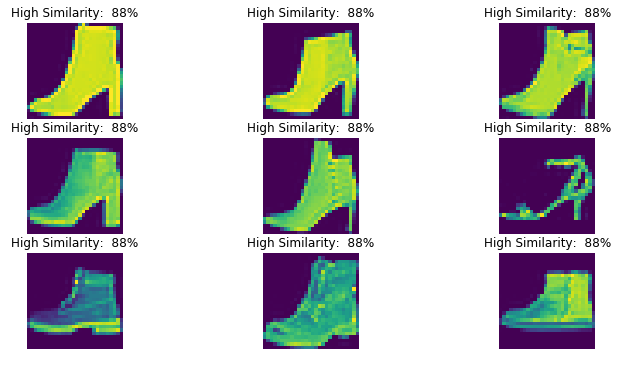

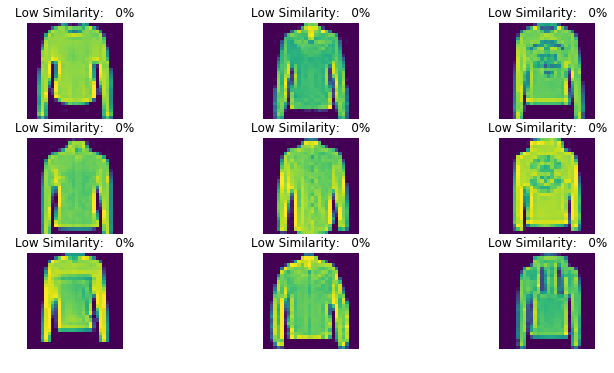

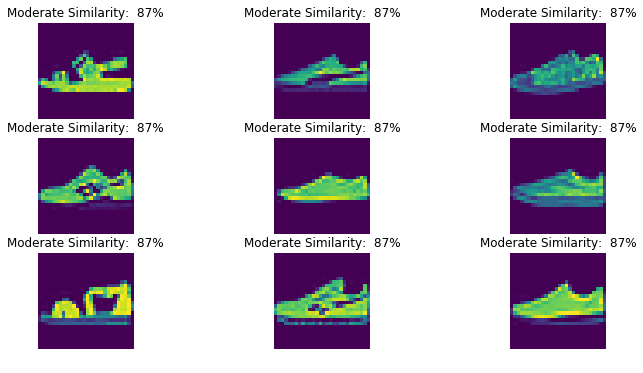

In [104]:
pred = make_predict(x_train[0], n_show)